<a href="https://colab.research.google.com/github/jchen8000/MachineLearning/blob/master/6%20Recommender%20System/recommender_system_content_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender System Content Based

In [0]:

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la 
import scipy.io 
import scipy.optimize #Use for fmincg

## 1. Movie ratings dataset

In [2]:

# !wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!wget "https://github.com/jchen8000/MachineLearning/blob/master/6%20Recommender%20System/ml-100k.zip?raw=true"
!mv ml-100k* ml-100k.zip
!unzip ml-100k.zip
!ls ml-100k/

--2019-07-26 01:28:04--  https://github.com/jchen8000/MachineLearning/blob/master/6%20Recommender%20System/ml-100k.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jchen8000/MachineLearning/raw/master/6%20Recommender%20System/ml-100k.zip [following]
--2019-07-26 01:28:04--  https://github.com/jchen8000/MachineLearning/raw/master/6%20Recommender%20System/ml-100k.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jchen8000/MachineLearning/master/6%20Recommender%20System/ml-100k.zip [following]
--2019-07-26 01:28:04--  https://raw.githubusercontent.com/jchen8000/MachineLearning/master/6%20Recommender%20System/ml-100k.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ..

In [3]:
dataset = pd.read_csv("ml-100k/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:

items = pd.read_csv("ml-100k/u.item",
                    sep='|',
                    names="movie_id|movie_title|release_date|video_release_date|IMDb_URL|unknown|Action|Adventure|Animation|Childrens|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|War|Western|".split("|"),
                    encoding="latin-1")
items.head()




,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,NaN


In [5]:
#Set user_id starting from 0 - number_users-1, and same for item_id
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
items.movie_id = items.movie_id.astype('category').cat.codes.values

num_users, num_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
print("Number of Users:", num_users, "; Number of Items:", num_movies, "; Rating is from", dataset.rating.min(), "to", dataset.rating.max())

Number of Users: 943 ; Number of Items: 1682 ; Rating is from 1 to 5


In [0]:
# Get movie features from dataset
X = items.iloc[:,6:24].values

Y = np.zeros((num_movies, num_users))

for index, row in dataset.iterrows():
     # access data using column names
     i_item = row['item_id']
     i_user = row['user_id']
     i_rating = row['rating']
     Y[i_item,i_user] = i_rating

R = (Y>=1)   
R = R.astype('float64')
 

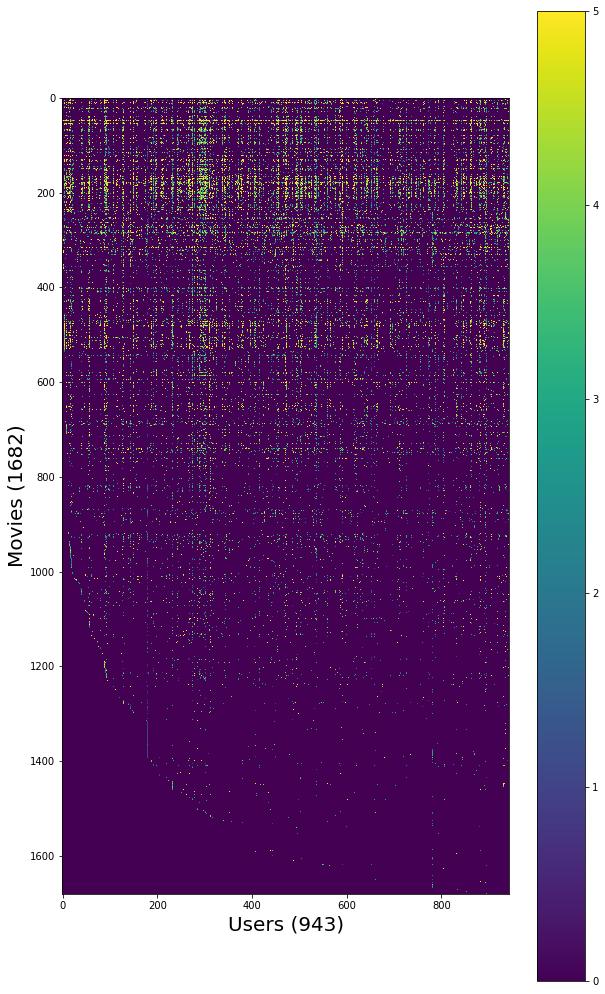

In [7]:
fig = plt.figure(figsize=(10,10*(1682./943.)))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies (%d)'%num_movies,fontsize=20)
plt.xlabel('Users (%d)'%num_users,fontsize=20)
plt.show()

## 2. Find related movies based on the features

**How Finding Related Movies**

For each product $i$, we have or learn a feature vector $x^{(i)} \in \mathbb{R}^{n}$

e.g. $x_1$ = romance, $x_2$ = action, $x_3$ = comedy, ..., $x_n$ =...

Small $||x^{(i)} - x^{(j)}||$ means $j$ and $i$ are ***SIMILAR***

5 most similar movies to movie $i:$

Find the 5 movies $j$ with the smallest $||x^{(i)} - x^{(j)}||$

In [8]:
theMovie = 'Toy Story (1995)'

print("The GOAL is to find movies that similar to: ", theMovie)
#items.loc[items['movie_title'] == theMovie]


The GOAL is to find movies that similar to:  Toy Story (1995)


In [0]:
item_idx = items.loc[items['movie_title'] == theMovie]['movie_id'].values[0]
v = X[item_idx]

n = la.norm((X-v), axis=1)
items['norm'] = n

In [10]:
print("THE TOP TEN MOVIES SIMILAR TO: ", theMovie)
items.sort_values(by=['norm']).head(10)[['norm', 'movie_title', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Musical', 'Mystery','Romance','Sci-Fi']]



THE TOP TEN MOVIES SIMILAR TO:  Toy Story (1995)


,norm,movie_title,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Musical,Mystery,Romance,Sci-Fi
0,0.0,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0
421,0.0,Aladdin and the King of Thieves (1996),0,0,1,1,1,0,0,0,0,0,0,0,0
239,1.0,Beavis and Butt-head Do America (1996),0,0,1,0,1,0,0,0,0,0,0,0,0
62,1.0,"Santa Clause, The (1994)",0,0,0,1,1,0,0,0,0,0,0,0,0
1065,1.0,Balto (1995),0,0,1,1,0,0,0,0,0,0,0,0,0
1077,1.0,Oliver & Company (1988),0,0,1,1,0,0,0,0,0,0,0,0,0
624,1.0,"Sword in the Stone, The (1963)",0,0,1,1,0,0,0,0,0,0,0,0,0
622,1.0,Angels in the Outfield (1994),0,0,0,1,1,0,0,0,0,0,0,0,0
93,1.0,Home Alone (1990),0,0,0,1,1,0,0,0,0,0,0,0,0
94,1.0,Aladdin (1992),0,0,1,1,1,0,0,0,0,1,0,0,0


## 3. Build and Train the model

**Given features $x^{(1)},...,x^{(n_m)}, \textrm{ to calculate  }\theta^{(1)},...,\theta^{(n_u)} \textrm{:}$**

**Cost Function:**

$\qquad \displaystyle\min_{\theta^{(1)},...,\theta^{(n_u)} } J = \frac{1}{2}\sum_{j=1}^{n_u}\sum_{i:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2 + \frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^n(\theta_k^{(j)})^2$


**Gradient Decent:**

$\qquad \displaystyle\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})x_k^{(i)}+\lambda \theta_k^{(j)}$

In [0]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row)
    This is important because without this, a user who hasn't rated any movies
    will have a predicted score of 0 for every movie, when in reality
    they should have a predicted score of [average score of that movie].
    """

    # The mean is only counting movies that were rated
    Ymean = np.sum(Y,axis=1)/np.sum(R,axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    
    return Y-Ymean, Ymean
  
  
def flattenParams(Theta):
    """
    Hand this function an X matrix and a Theta matrix and it will flatten
    it into into one long (nm*nf + nu*nf,1) shaped numpy array
    """
    return Theta.flatten()

# A utility function to re-shape the X and Theta will probably come in handy
def reshapeParams(flattened_Theta, num_users, num_features):
    assert flattened_Theta.shape[0] == int(num_users*num_features)
    
    reTheta = flattened_Theta[:int(num_users*num_features)].reshape((num_users,num_features))
    
    return reTheta  

In [0]:
def cofiCostFunc(params, X, Y, R, num_users, num_movies, num_features, lambda_=0):
    #COFICOSTFUNC Collaborative filtering cost function
    #   [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    #   num_features, lambda) returns the cost and gradient for the
    #   collaborative filtering problem.
    #
    
    Theta = reshapeParams(params, num_users, num_features)

    # These are the return values
    J = 0
    Theta_grad = np.zeros(Theta.shape)
    
    
    ### COST FUNCTION
    # X * Theta performed according to low rank matrix vectorization
    squared_error = np.power(np.dot(X,Theta.T) - Y,2)

    # for cost function, sum only i,j for which R(i,j)=1
    J = (1/2.) * np.sum(squared_error * R)
    J = J + (lambda_/2.)*( np.sum( np.power(Theta, 2) ) + np.sum( np.power(X, 2) ) )

    ### GRADIENTS

    Theta_grad = np.dot((( np.dot(X, Theta.T) - Y ) * R).T, X)
    Theta_grad = Theta_grad + lambda_*Theta
    
    grad = flattenParams(Theta_grad)
    
    return J, grad

In [0]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = X.shape[1]

Ynorm, Ymean = normalizeRatings(Y,R)

In [0]:
# Set Initial Parameters (Theta)
Theta = np.random.randn(num_users, num_features)

initial_parameters  = flattenParams(Theta)

# Set options
maxiter = 100
options = {'disp': True, 'maxiter':maxiter}
lambda_=10

In [0]:
from scipy.optimize import minimize

# Create "short hand" for the cost function to be minimized
def costFunc(initial_parameters):
    return cofiCostFunc(initial_parameters, X, Y, R, num_users, num_movies, num_features, lambda_)


results = minimize(costFunc, x0=initial_parameters, options=options, method="L-BFGS-B", jac=True)


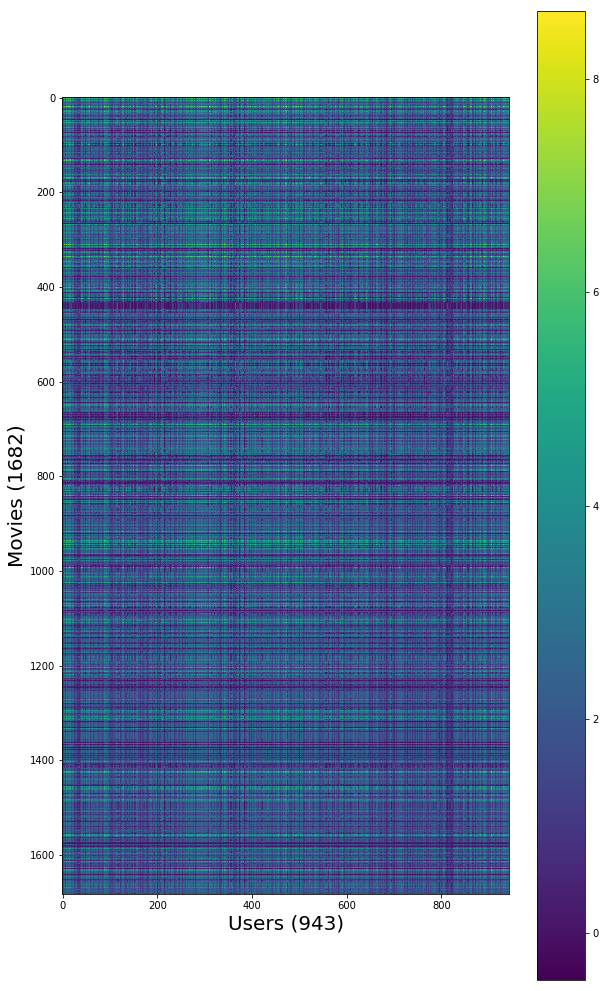

In [16]:
Theta = reshapeParams(results['x'], num_users, num_features)
prediction_matrix = X.dot(Theta.T)

fig = plt.figure(figsize=(10,10*(1682./943.)))
plt.imshow(prediction_matrix)
plt.colorbar()
plt.ylabel('Movies (%d)'%num_movies,fontsize=20)
plt.xlabel('Users (%d)'%num_users,fontsize=20)
plt.show()